In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt 

In [69]:
%%time
df = pd.read_excel('/Users/prajwal/Desktop/nepse/nepse_vs_sp500 (updated).xlsx')
df = df.set_index(df.Date)
nepse = pd.DataFrame(df.NEPSE)

CPU times: user 917 ms, sys: 142 ms, total: 1.06 s
Wall time: 1.39 s


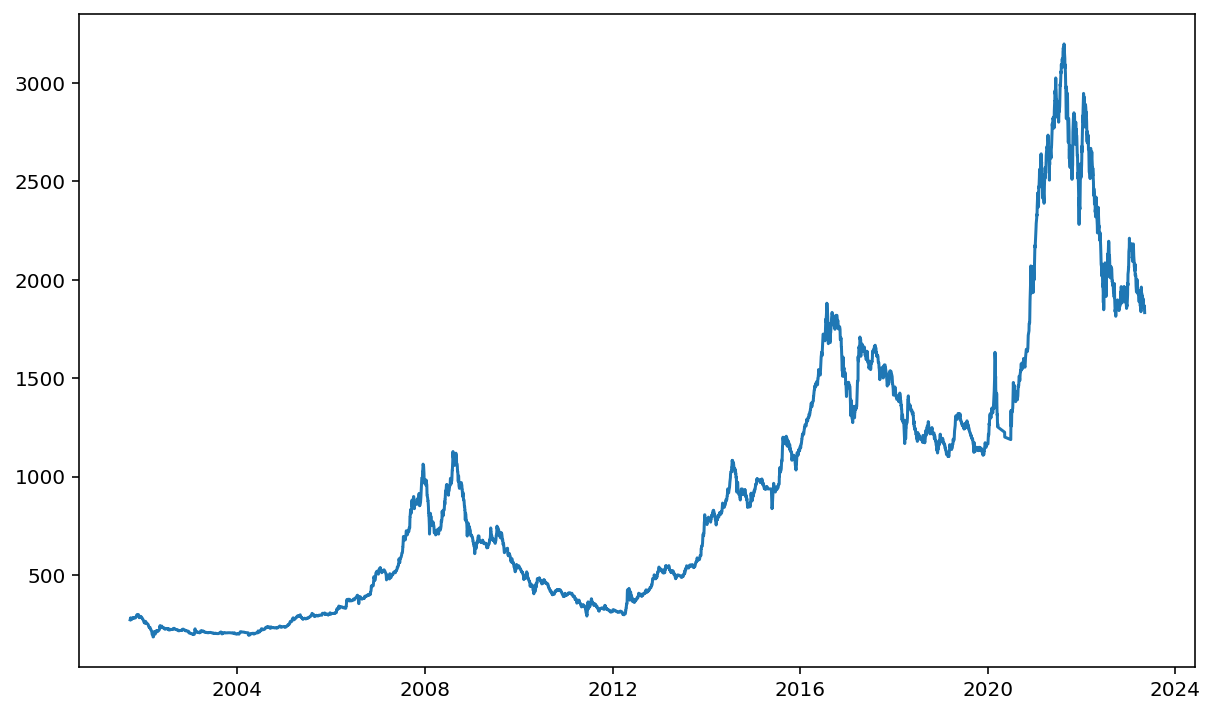

In [70]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(10,6))
plt.plot(nepse)

In [71]:
# groupby year and determine the daily percent change by year, and add it as a column to df
nepse['returns'] = nepse.NEPSE.pct_change()
nepse['log_returns'] = np.log(nepse['NEPSE']/nepse['NEPSE'].shift(1))
nepse['year'] = nepse.index.year
nepse['month'] = nepse.index.month
nepse['day_of_the_month'] = nepse.index.day

<AxesSubplot:xlabel='Year'>

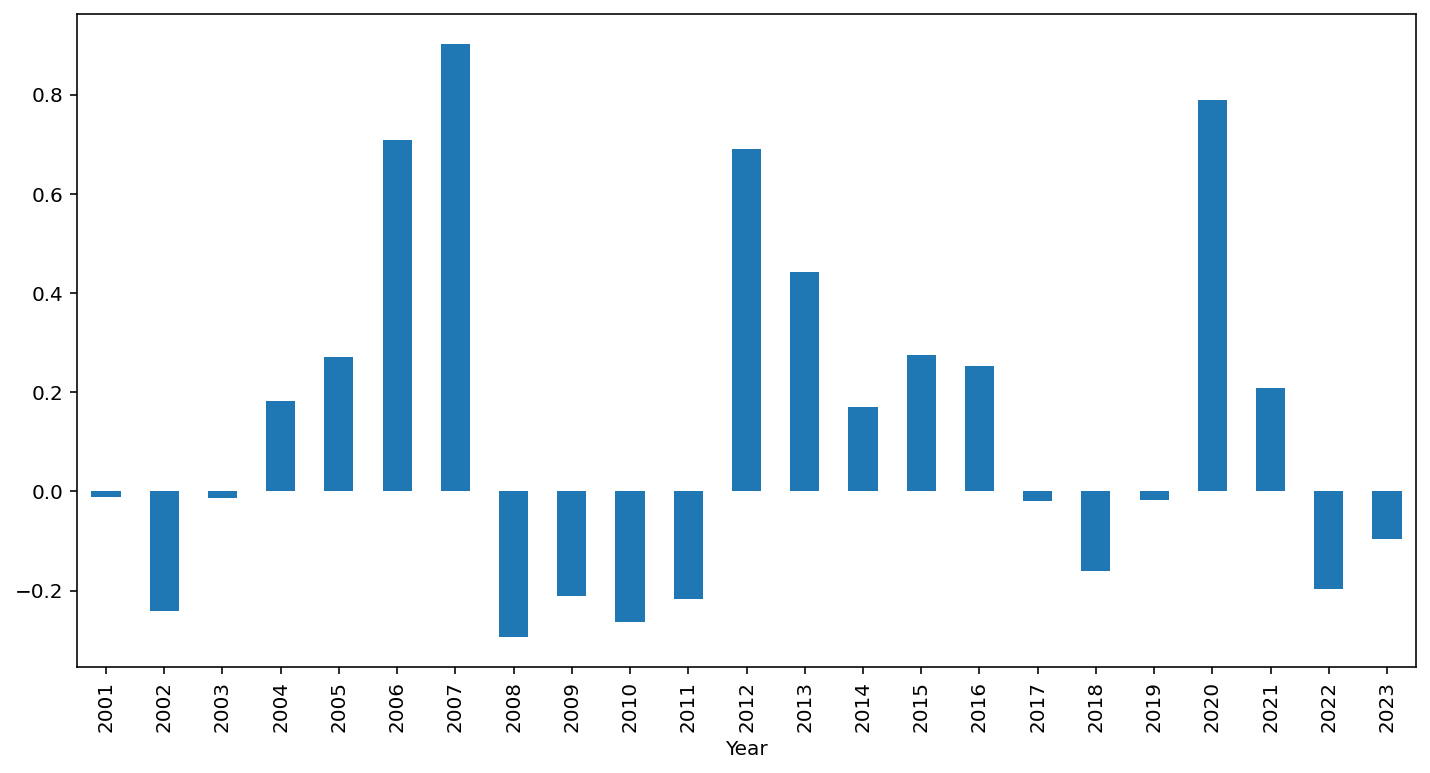

In [105]:
grouped_by_day = nepse.groupby('day_of_the_month').log_returns.mean()
grouped_by_month = nepse.groupby('month').log_returns.mean()
grouped_by_year = nepse.groupby('year').log_returns.mean()

day_returns = nepse.groupby('day_of_the_month').returns.sum()
month_returns = nepse.groupby('month').returns.sum()
yearly_returns = nepse.groupby('year').returns.sum()

cumulative_yearly_rets = pd.DataFrame(nepse['NEPSE'].pct_change().resample('Y').agg(lambda x: (1+x).prod()-1))
cumulative_yearly_rets['Year'] = cumulative_yearly_rets.index.year
cumulative_yearly_rets = cumulative_yearly_rets.set_index(cumulative_yearly_rets.Year)
cumulative_yearly_rets.NEPSE.plot.bar(figsize=(12,6))

## Get expected (annualized) returns

In [121]:
def getExpectedReturns(df, price_col_name, annualised=True, frequency='daily'):
    
    daily_returns = df[price_col_name].pct_change()
    weekly_returns = df[price_col_name].resample('W').mean().pct_change()
    monthly_returns = df[price_col_name].resample('M').mean().pct_change()
    
    exp_daily_return = daily_returns.mean()
    exp_weekly_return = weekly_returns.mean()
    exp_monthly_return = monthly_returns.mean()
    
    daily_frequency = 250
    weekly_frequency = 52
    monthly_frequency = 12
    
    if annualised == True:
        if frequency == 'daily':
            annualised_return = (1+exp_daily_return)**daily_frequency - 1
        elif frequency == 'weekly':
            annualised_return = (1+exp_weekly_return)**weekly_frequency - 1
        elif frequency == 'monthly':
            annualised_return = (1+exp_monthly_return)**monthly_frequency - 1
            
        return annualised_return
    else:
        if frequency == 'weekly':
            return exp_weekly_return
        elif frequency == 'monthly':
            return exp_monthly_return
    
    return exp_daily_return

In [181]:
getExpectedReturns(nepse, 'NEPSE', annualised=True, frequency='daily')

0.1144548646247121

In [182]:
def getAnnualisedStd(df, col_name, return_frequency='daily'):
    daily_returns = df[col_name].pct_change()
    weekly_returns = df[col_name].resample('W').ffill().pct_change()
    monthly_returns = df[col_name].resample('M').ffill().pct_change() 
    
    daily_frequency = 250
    weekly_frequency = 52
    monthly_frequency = 12
    
    if return_frequency == 'daily':
        var = np.var(daily_returns)
        std = np.std(daily_returns)
        annualised_std = std*np.sqrt(daily_frequency)
        return annualised_std
    elif return_frequency == 'weekly':
        var = np.var(weekly_returns)
        std = np.std(weekly_returns)
        annualised_std = std*np.sqrt(weekly_frequency)
        return annualised_std
    elif return_frequency == 'monthly':
        var = np.var(monthly_returns)
        std = np.std(monthly_returns)
        annualised_std = std*np.sqrt(monthly_frequency)
        return annualised_std
    

In [186]:
getAnnualisedStd(nepse, 'NEPSE', return_frequency='daily')

0.19686607878178813

## Returns Histogram

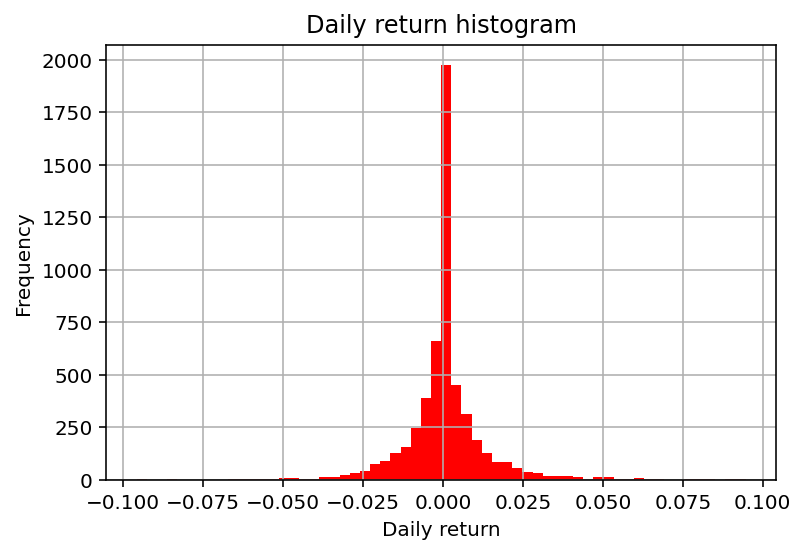

In [139]:
# Plot the histogram
nepse['returns'].hist(bins=60, color='red')
plt.ylabel('Frequency')
plt.xlabel('Daily return')
plt.title('Daily return histogram')
plt.show()

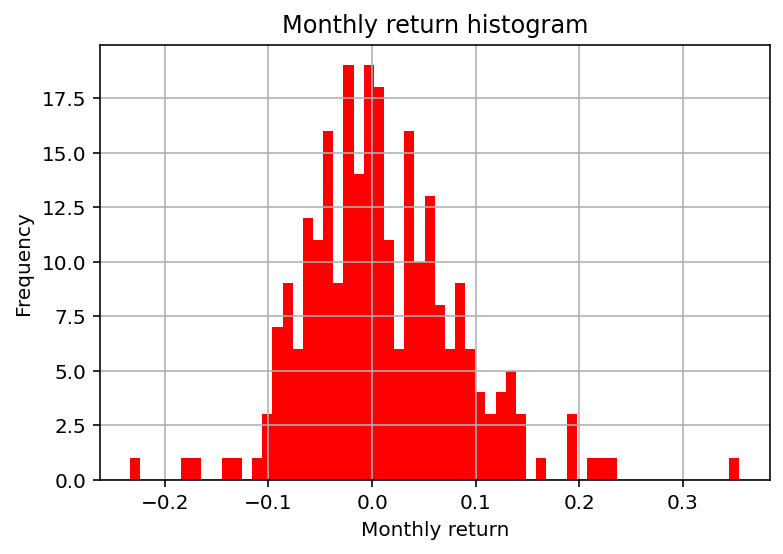

In [148]:
# Plot the histogram
mlt_ret = nepse.NEPSE.pct_change().resample('M').agg(lambda x: (1+x).prod()-1)
mlt_ret.hist(bins=60, color='red')
plt.ylabel('Frequency')
plt.xlabel('Monthly return')
plt.title('Monthly return histogram')
plt.show()

## Volatility 

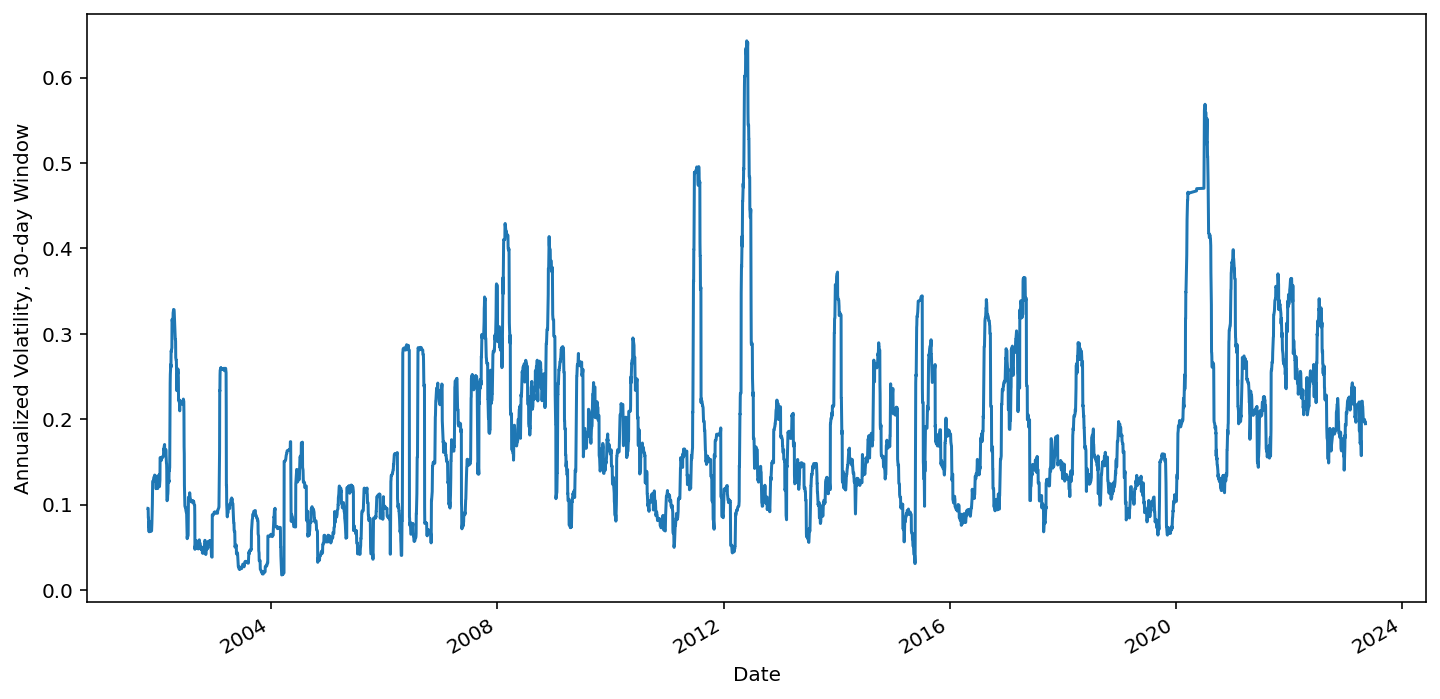

In [153]:
# Calculate the 30-day rolling window of portfolio returns
returns_windowed = nepse.returns.rolling(30)

# Compute the annualized volatility series
volatility_series = returns_windowed.std()*np.sqrt(252)

# Plot the index volatility
volatility_series.plot(figsize=(12,6)).set_ylabel("Annualized Volatility, 30-day Window")
plt.show()

## VaR

In [180]:
from scipy.stats import norm

mlt_mean = np.mean(nepse.NEPSE.resample('M').ffill().pct_change())
mlt_std = np.std(nepse.NEPSE.resample('M').ffill().pct_change())

VaR_90 = norm.ppf(1-0.9, mlt_mean, mlt_std)
VaR_95 = norm.ppf(1-0.95, mlt_mean, mlt_std)
VaR_99 = norm.ppf(1-0.99, mlt_mean, mlt_std)

print(VaR_90)
print(VaR_95)
print(VaR_99)

-0.08515170220082097
-0.11212148465665897
-0.1627123112479824


In [165]:
var90 = mlt_ret.quantile(0.1)
var95 = mlt_ret.quantile(0.05)
var99 = mlt_ret.quantile(0.01)
print(var90)
print(var95)
print(var99)

-0.07392996108949434
-0.08766761259016964
-0.1546926384467705


## Drawdown

In [212]:
def drawdown(rets: pd.Series):
    """
    Takes a timeseries of asset returns
    Computes and returns dataframe that contains:
    the wealth index
    previous peaks
    percentage drawdown
    """
    wealth_index = 1*(1+rets).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, "Peaks":previous_peaks, "Drawdowns": drawdowns})

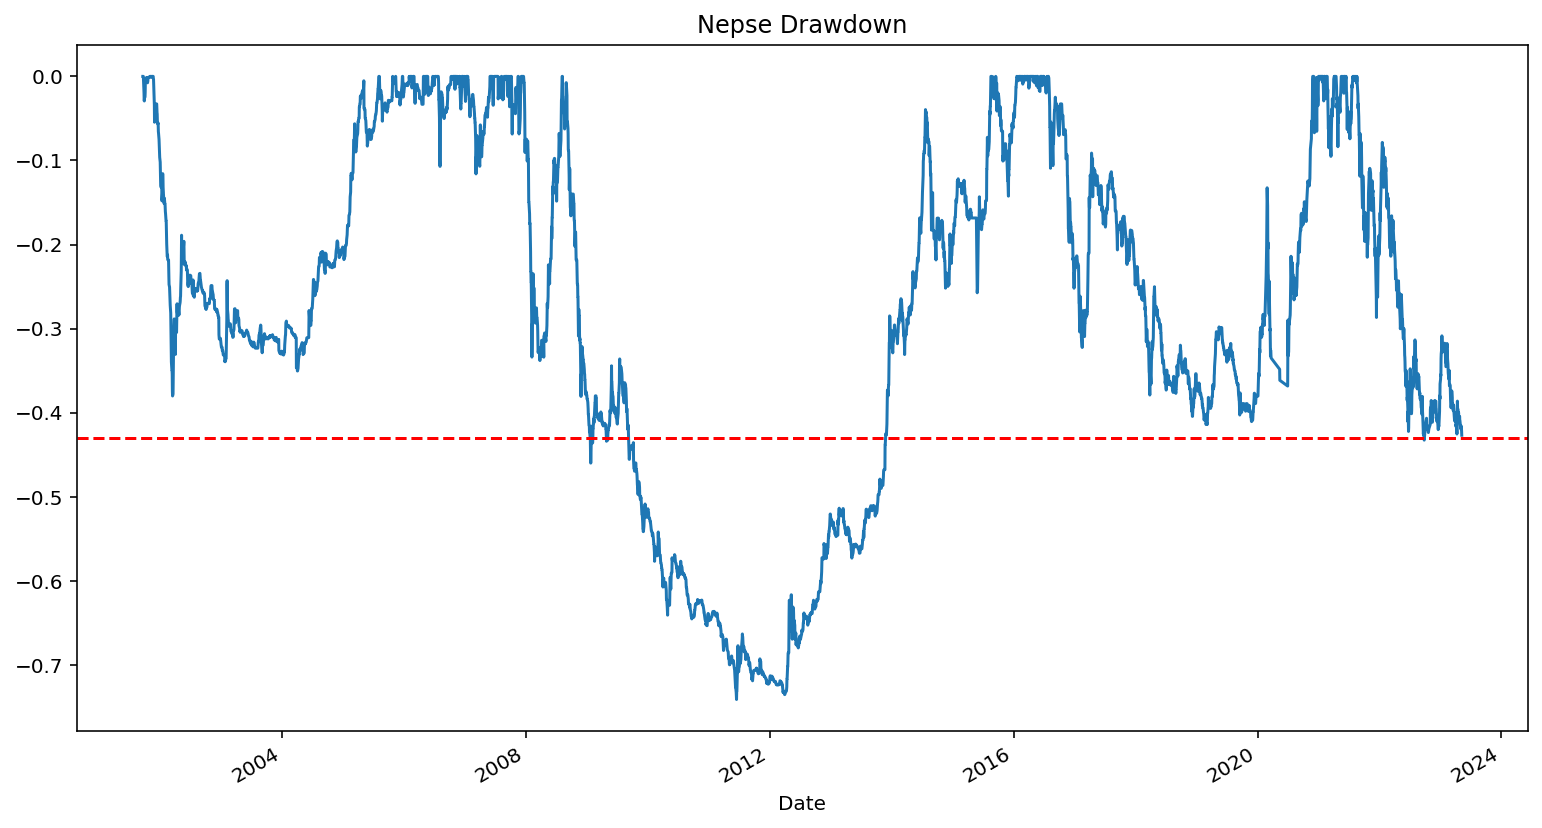

In [217]:
drawdown(nepse.returns).Drawdowns.plot(title='Nepse Drawdown', figsize=(13,7))
plt.axhline(y=-.43, color='r', linestyle='--')

In [214]:
drawdown(nepse.returns)

,Wealth,Peaks,Drawdowns
Date,,,
2001-09-17,NaN,NaN,NaN
2001-09-18,1.007765,1.007765,0.000000
2001-09-19,1.025310,1.025310,0.000000
2001-09-20,1.025310,1.025310,0.000000
2001-09-21,1.037984,1.037984,0.000000
...,...,...,...
2023-05-02,6.836380,11.716054,-0.416495
2023-05-03,6.801949,11.716054,-0.419434
2023-05-04,6.848577,11.716054,-0.415454


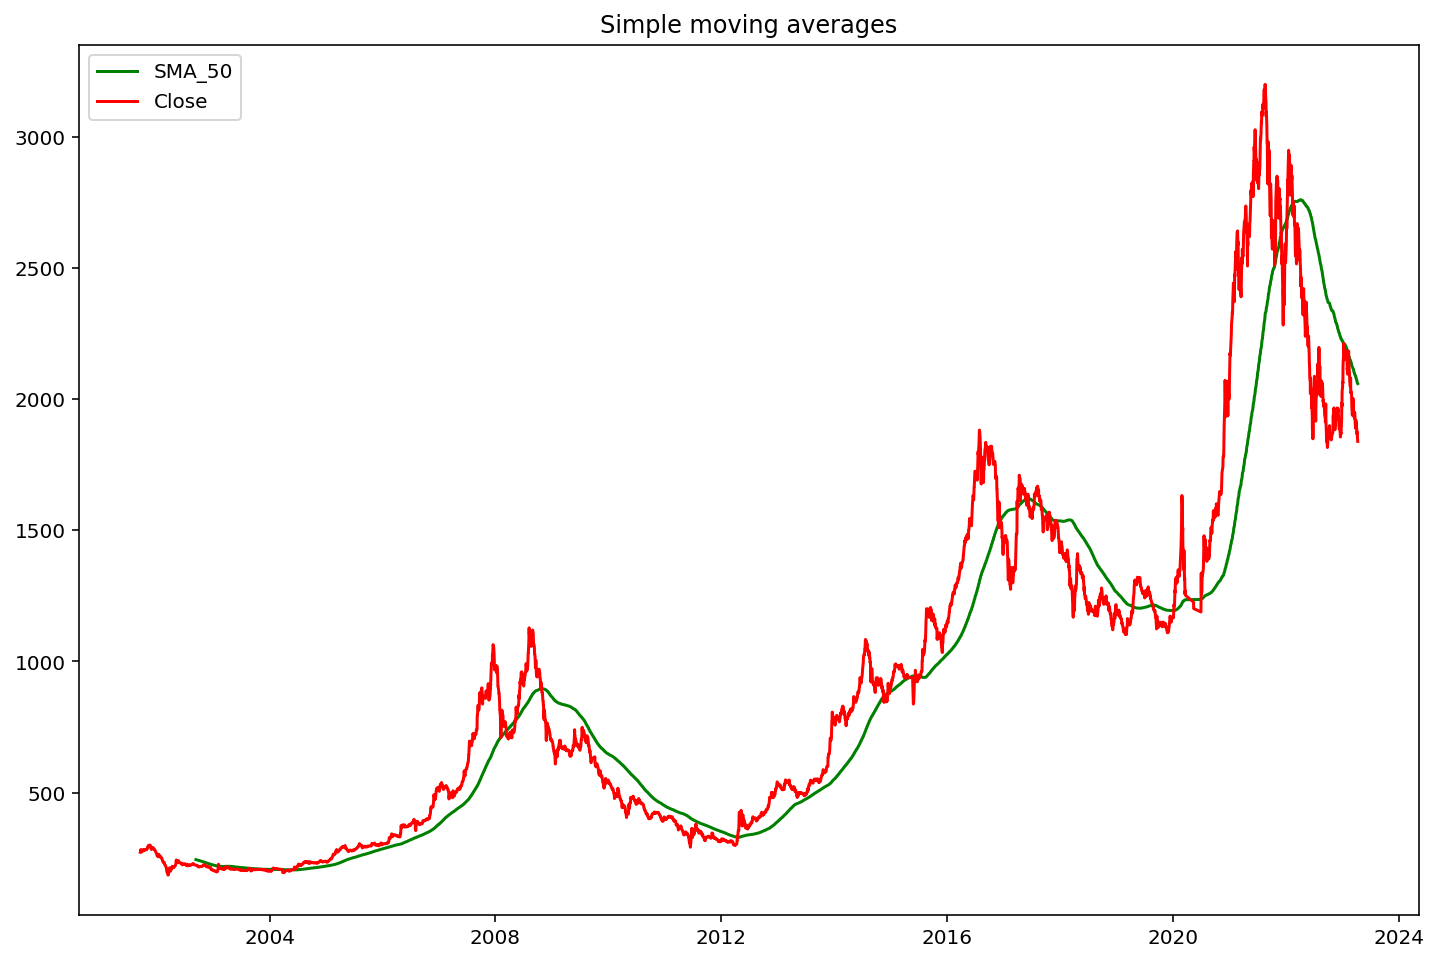

In [9]:
# Calculate SMA
nepse['sma_50'] = nepse['NEPSE'].rolling(250).mean()

# Plot the SMA
plt.figure(figsize=(12,8))
plt.plot(nepse['sma_50'], color='green', label='SMA_50')
# Plot the close price
plt.plot(nepse['NEPSE'], color='red', label='Close')

# Customize and show the plot
plt.title('Simple moving averages')
plt.legend()
plt.show()

In [48]:
pip install bt

     |████████████████████████████████| 259 kB 101 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [49]:
import bt
import yfinance as yf
from backtesting import Backtest, Strategy

In [38]:
%%time
faang = ['AAPL', 'AMZN', 'META', 'GOOG', 'NFLX']
faang_data = yf.download(faang, start = '2020-06-01')['Adj Close']
sp500 = 

[*********************100%***********************]  5 of 5 completed
CPU times: user 324 ms, sys: 43.9 ms, total: 368 ms
Wall time: 1.29 s


<ipython-input-57-8ff21ee60226>:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


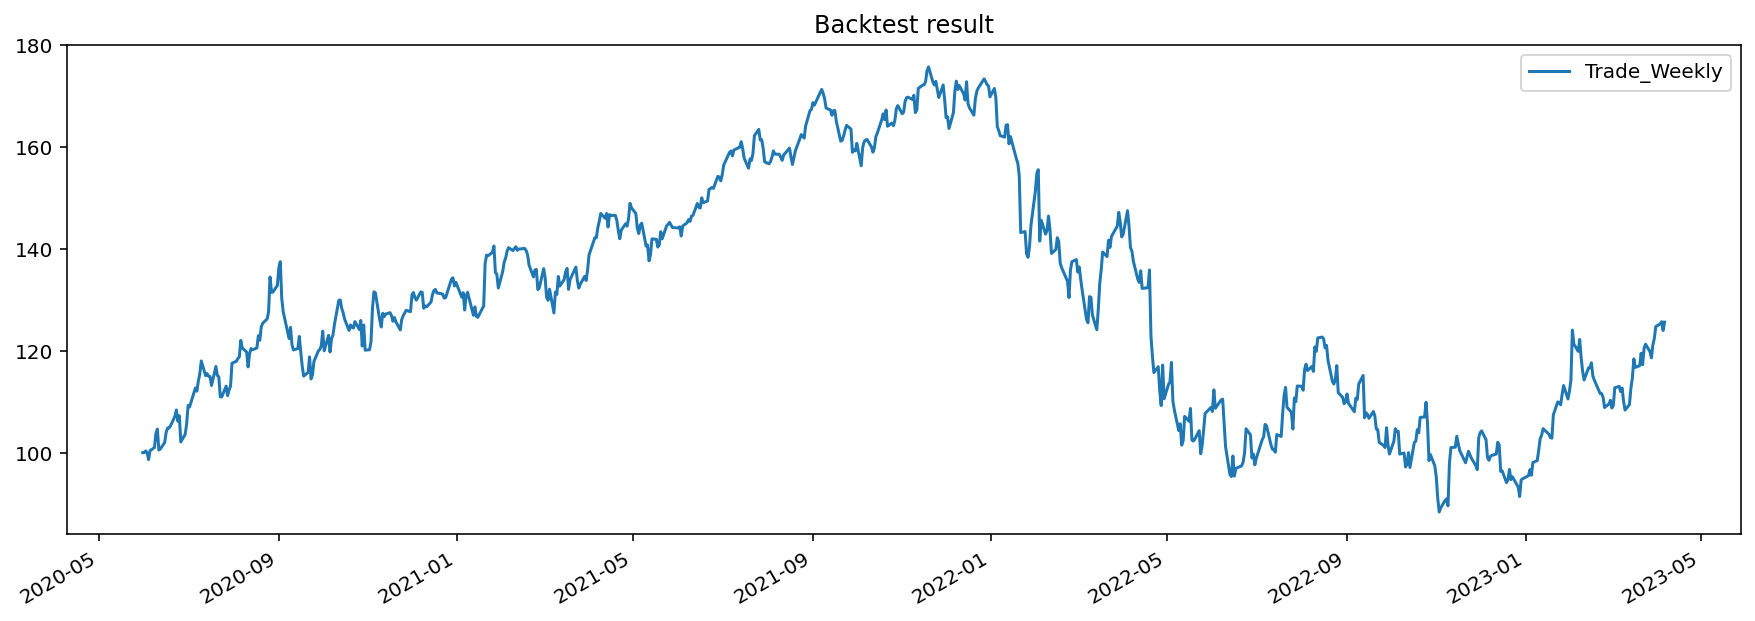

In [57]:
# Define the strategy
bt_strategy = bt.Strategy('Trade_Weekly', 
                         [bt.algos.RunWeekly(),
                          bt.algos.SelectAll(),
                          bt.algos.WeighEqually(),
                          bt.algos.Rebalance()])

# Create a backtest
bt_test = bt.Backtest(bt_strategy, faang_data)
# Run the backtest
bt_res = bt.run(bt_test)

bt_res.plot(title="Backtest result")
plt.show()

In [18]:
pip install --upgrade pip

     |████████████████████████████████| 2.1 MB 133 kB/s eta 0:00:01     |████████████████████████        | 1.5 MB 93 kB/s eta 0:00:06
  Attempting uninstall: pip
    Found existing installation: pip 21.0.1
    Uninstalling pip-21.0.1:
      Successfully uninstalled pip-21.0.1
Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install TA-lib


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.3 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install TA-lib

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install -U numpy

  Using cached numpy-1.24.2-cp38-cp38-macosx_10_9_x86_64.whl (19.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.6.2 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import talib

In [22]:
nepse['SMA'] = talib.SMA(nepse['NEPSE'], timeperiod=200)

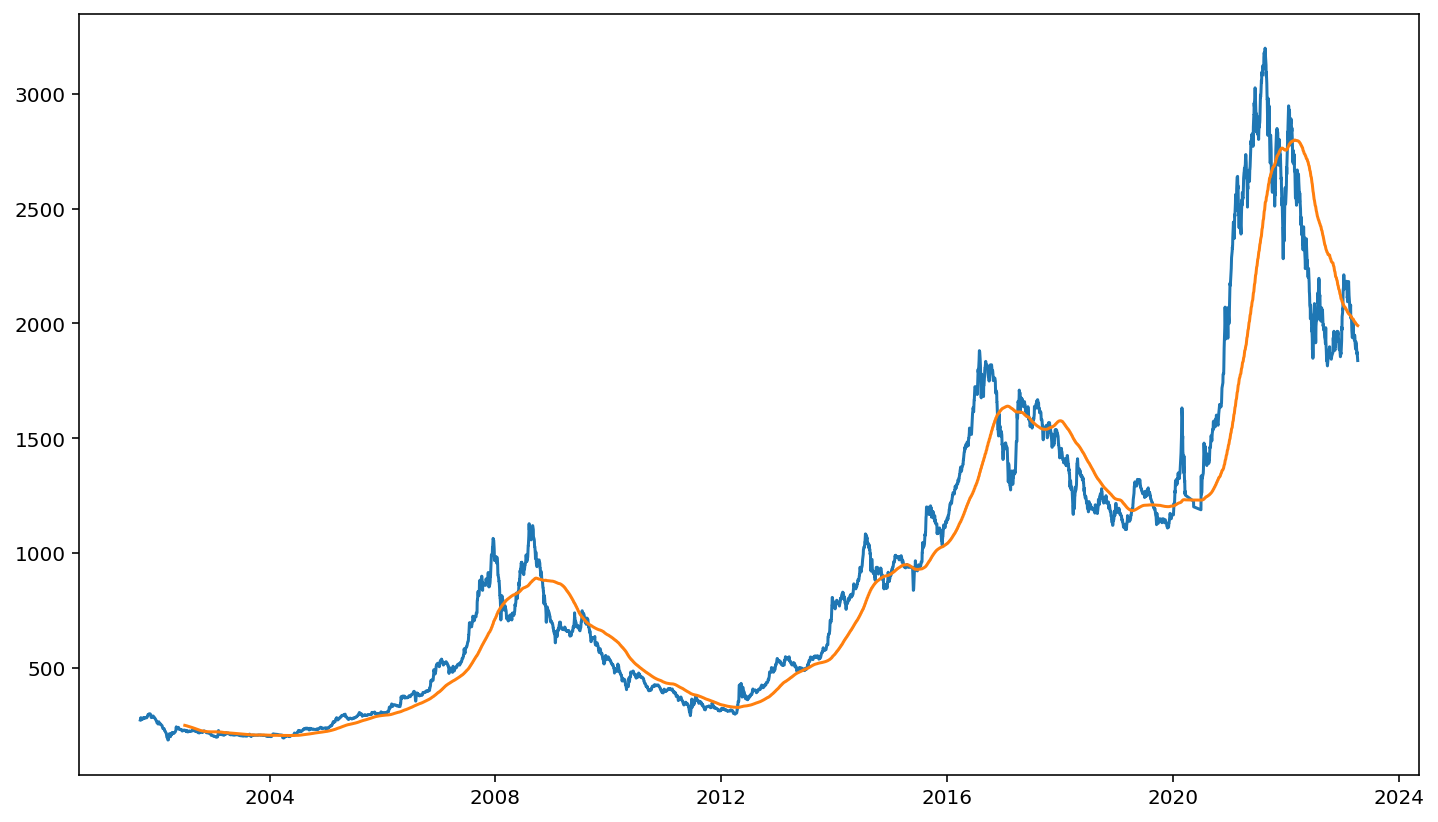

In [23]:
plt.figure(figsize=(12,7))
plt.plot(nepse.NEPSE)
plt.plot(nepse.SMA)

In [156]:
%%time
df = pd.read_csv('/Users/prajwal/Desktop/Thesis/FACTOR INVESTING/data/stock_data_adjusted.csv')
df = df[["trading_date", "ticker", "closingPrice", "volume"]]
df.rename(columns={'trading_date': 'date'}, inplace = True)
df.set_index('date', inplace = True)
df.index = pd.to_datetime(df.index)
new_df = pd.pivot_table(df, values='closingPrice', index='date', columns='ticker')

CPU times: user 683 ms, sys: 234 ms, total: 917 ms
Wall time: 1.18 s


<AxesSubplot:xlabel='std', ylabel='mean'>

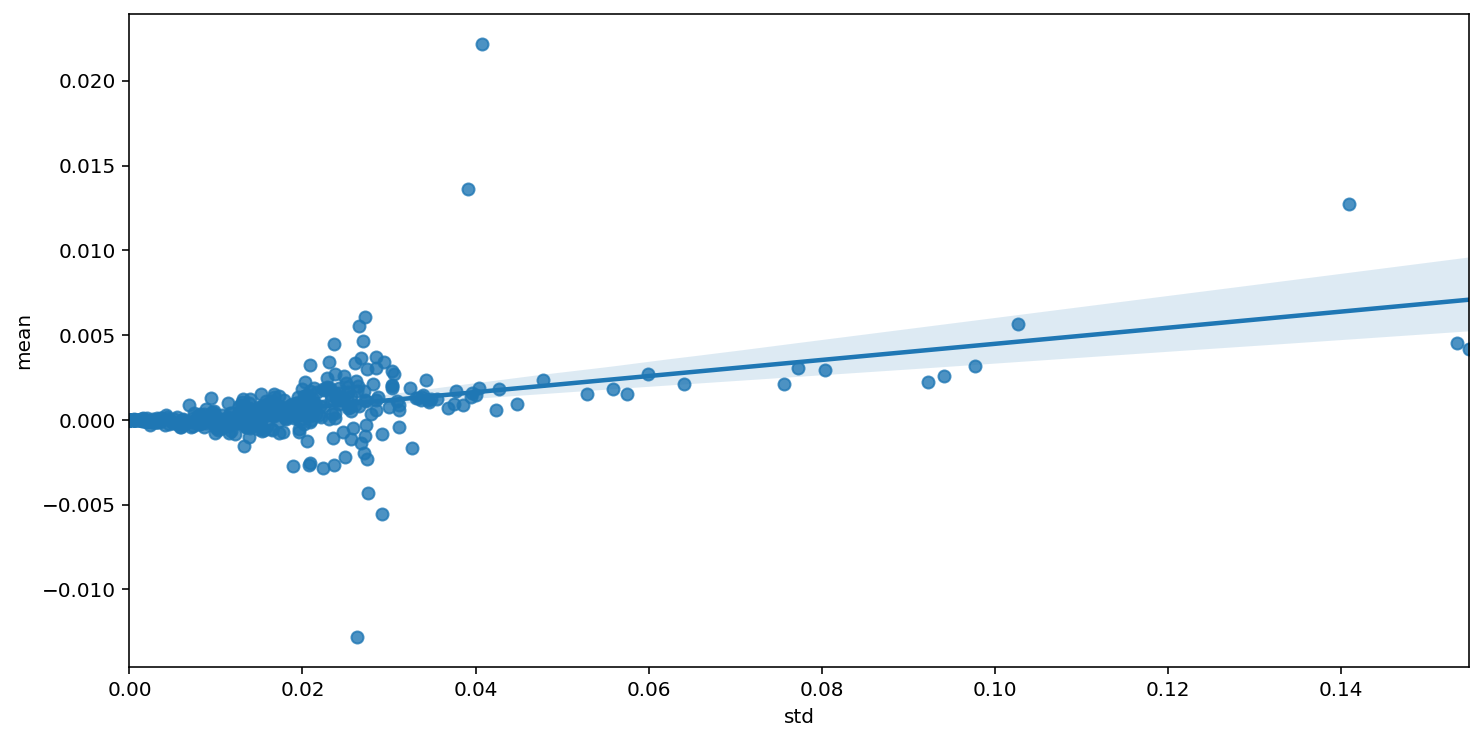

In [157]:
returns = new_df.pct_change()
summary = returns.agg(['mean', 'std']).T

%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(12,6))
sns.regplot(x=summary['std'], y=summary['mean'])